Generating Beautiful Images from the Blockchain 
==================

An example of visualizing Cardano transactions on the blockchain using AI via LLMs.

## What is it?

This project is an example of generating awesome images from the Cardano blockchain by sending details of a transaction to an AI LLM for returning an image.

Transaction details that are sent along in the prompt to the AI incude the transaction hash, sender wallet address, receiver wallet address, and amount of ADA. The resulting prompt is then used to generate an image through the LLM. The final step draws text on the image to show the transaction details.


In [ ]:
%pip install seaborn
%pip install pylatexenc
%pip install ipympl
%pip install python-dotenv

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as Img
from dotenv import load_dotenv

import time
import json
import requests
import os
import io
import math
import uuid

# Load environment variables from .env file
load_dotenv(override=True)

## Loading transaction details from Cardano

We begin by loading the details for a specific transaction in the Cardano blockchain. This allows extracting the transaction id (hash), ADA amount sent, sender wallet address, and receiver wallet address. These values will be later when constructing the prompt for the LLM.

We'll also define a method for generating the prompt based upon the amount of ADA being sent in the transaction. Multiple bins separate balance amounts into differnt descriptions of imagery for the generated picture. For example, if a transaction is less than 5 ADA, the picture should only contain a small flower or a single tree. Whereas, if the transaction is greater than 100 ADA, the picture will include a dramatic and intense sunset.

The key to generating the picture with the LLM is in the construction of the prompt. Notice how details from the transaction are included within the prompt text.

```python
prompt = f"Generate an image based on the following transaction details: \
    Imagine a scene that represents the flow of value and connection between these entities. \
    Include {objects} with {color_scheme}. \
    Transaction ID: {tx_details.tx_id}, ADA Amount: {tx_details.ada_amount}, Sender: {tx_details.sender}, Receiver: {tx_details.receiver}."
```

In [24]:
from blockfrost import BlockFrostApi, ApiUrls

# Initialize BlockFrost API
api = BlockFrostApi(
    project_id=os.getenv('BLOCKFROST_PROJECT_ID'),
    base_url=ApiUrls.preview.value,
)

class TransactionDetails:
    def __init__(self, tx_id, ada_amount, sender, receiver):
        self.tx_id = tx_id
        self.ada_amount = ada_amount
        self.sender = sender
        self.receiver = receiver

def fetch_transaction_details(tx_id):
    # Fetch transaction details from BlockFrost
    tx_details = api.transaction_utxos(tx_id)
    ada_amount = sum(int(output.amount[0].quantity) for output in tx_details.outputs if not output.collateral) / 1000000  # Convert lovelace to ADA
    sender = tx_details.inputs[0].address
    receiver = tx_details.outputs[0].address
    return TransactionDetails(tx_id, ada_amount, sender, receiver)

def generate_prompt(tx_details):
    # Define objects and color schemes based on ADA amount
    if tx_details.ada_amount < 5:
        objects = "a small flower, a single tree"
        color_scheme = "soft pastel colors"
    elif tx_details.ada_amount < 10:
        objects = "a garden, a few trees"
        color_scheme = "light and vibrant colors"
    elif tx_details.ada_amount < 20:
        objects = "a park, a small pond"
        color_scheme = "bright and cheerful colors"
    elif tx_details.ada_amount < 30:
        objects = "a meadow, a stream"
        color_scheme = "warm and inviting colors"
    elif tx_details.ada_amount < 40:
        objects = "a forest, a river"
        color_scheme = "rich and deep colors"
    elif tx_details.ada_amount < 50:
        objects = "a mountain range, a lake"
        color_scheme = "bold and striking colors"
    elif tx_details.ada_amount < 60:
        objects = "a desert, a cactus"
        color_scheme = "earthy and muted colors"
    elif tx_details.ada_amount < 70:
        objects = "a beach, a palm tree"
        color_scheme = "cool and refreshing colors"
    elif tx_details.ada_amount < 80:
        objects = "a cityscape, skyscrapers"
        color_scheme = "modern and sleek colors"
    elif tx_details.ada_amount < 90:
        objects = "a village, cottages"
        color_scheme = "quaint and charming colors"
    elif tx_details.ada_amount < 100:
        objects = "a castle, a moat"
        color_scheme = "regal and majestic colors"
    else:
        objects = "a vast landscape, a sunset"
        color_scheme = "dramatic and intense colors"

    prompt = f"Generate an image based on the following transaction details: \
Imagine a scene that represents the flow of value and connection between these entities. \
Include {objects} with {color_scheme}. \
Transaction ID: {tx_details.tx_id}, ADA Amount: {tx_details.ada_amount}, Sender: {tx_details.sender}, Receiver: {tx_details.receiver}."

    return prompt

## Generating the image

Images are generated by using the AI LLM from Hugging Face, specifically from [Stable Diffusion](https://huggingface.co/models?sort=created&search=stable-diffusion). The prompt is sent to the Stable Diffusion model via the API. After receiving the image, the transaction details are drawn as text in the image to give a more realistic and financial spin to the final product.

In [25]:
def generate_image_with_hf(prompt, filename, tx_details):
    """Generate an image with HuggingFace's API.

    Args:
        prompt (str): The prompt to use
        filename (str): The filename to save the image to

    Returns:
        str: The filename of the image
    """
    API_URL = f"https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-3.5-large"
    headers = {
        "Authorization": f"Bearer {os.getenv('HUGGINGFACE_API_KEY')}",
        "X-Use-Cache": "false",
    }

    retry_count = 0
    while retry_count < 10:
        response = requests.post(
            API_URL,
            headers=headers,
            json={
                "inputs": prompt,
            },
        )

        if response.ok:
            try:
                image = Image.open(io.BytesIO(response.content))

                # Draw text on the image.
                text = f"Transaction ID: {tx_details.tx_id}\nSender: {tx_details.sender}\nReceiver: {tx_details.receiver}"
                image = draw_text_on_image(image, text, f"{tx_details.ada_amount} ADA")

                # Save the image.
                image.save(filename)
                return f"Saved to disk:{filename}"
            except Exception as e:
                print(e)
                break
        else:
            error = json.loads(response.text)
            if "estimated_time" in error:
                delay = error["estimated_time"]
                print(response.text)
                print("Retrying in", delay)
                time.sleep(delay)
            else:
                raise Exception(error)
                
        retry_count += 1

    return f"Error creating image."

def draw_text_on_image(image, text, ada_amount):
    """Draw text on the image with a border and highlight the ADA amount.

    Args:
        image (PIL.Image): The image to draw on
        text (str): The text to draw
        ada_amount (str): The ADA amount to highlight

    Returns:
        PIL.Image: The image with the text drawn on it
    """
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("arial.ttf", 16)  # Smaller font size for regular text
    ada_font = ImageFont.truetype("arial.ttf", 60)  # Larger font size for ADA amount

    # Calculate text size and position
    text_bbox = draw.textbbox((10, 10), text, font=font)
    x, y = 10, 10

    # Draw border
    border_color = "hotpink"
    for offset in range(-1, 2):
        draw.text((x + offset, y), text, font=font, fill=border_color)
        draw.text((x, y + offset), text, font=font, fill=border_color)
        draw.text((x + offset, y + offset), text, font=font, fill=border_color)

    # Draw text
    draw.text((x, y), text, font=font, fill="white")

    # Highlight ADA amount
    ada_x = (image.width - draw.textbbox((0, 0), ada_amount, font=ada_font)[2]) // 2
    ada_y = y + text_bbox[3] + 10 # Position below the regular text
    for offset in range(-1, 2):
        draw.text((ada_x + offset, ada_y), ada_amount, font=ada_font, fill=border_color)
        draw.text((ada_x, ada_y + offset), ada_amount, font=ada_font, fill=border_color)
        draw.text((ada_x + offset, ada_y + offset), ada_amount, font=ada_font, fill=border_color)

    draw.text((ada_x, ada_y), ada_amount, font=ada_font, fill="white")

    return image


## Running the program

The program is executed by asking the user to enter a transaction id from the Cardano blockchain. You can find a list of recent transacations [here](https://preview.cardanoscan.io/transactions).


In [27]:
tx_id = input("Enter your transaction ID: ") or os.getenv('TRANSACTION_ID')
tx_details = fetch_transaction_details(tx_id)
prompt = generate_prompt(tx_details)
filename = os.path.join(os.getcwd(), "generated_image.png")
generate_image_with_hf(prompt, filename, tx_details)
print(f"Prompt: {prompt}\nImage saved as {filename}")

Prompt: Generate an image based on the following transaction details: Imagine a scene that represents the flow of value and connection between these entities. Include a small flower, a single tree with soft pastel colors. Transaction ID: 079112f6a5192c6eeae57de0607d61e07dea864efc2bbad7aa953795a5c56aae, ADA Amount: 2.163014, Sender: addr_test1vzyhdm9xcp7t8qwnwnspfu9v3tmmwwaw3fkhk076702cwsc25aqfj, Receiver: addr_test1qqqjdvdavgu930qn2jmuzp9kstjeldmpsxug0uds0mcpf3njgn84fjpwdahp4wvavp38t9ead0qr5mcr4uakskjpp6vqglkpdj.
Image saved as c:\Users\username\Documents\generative-cardano\generated_image.png


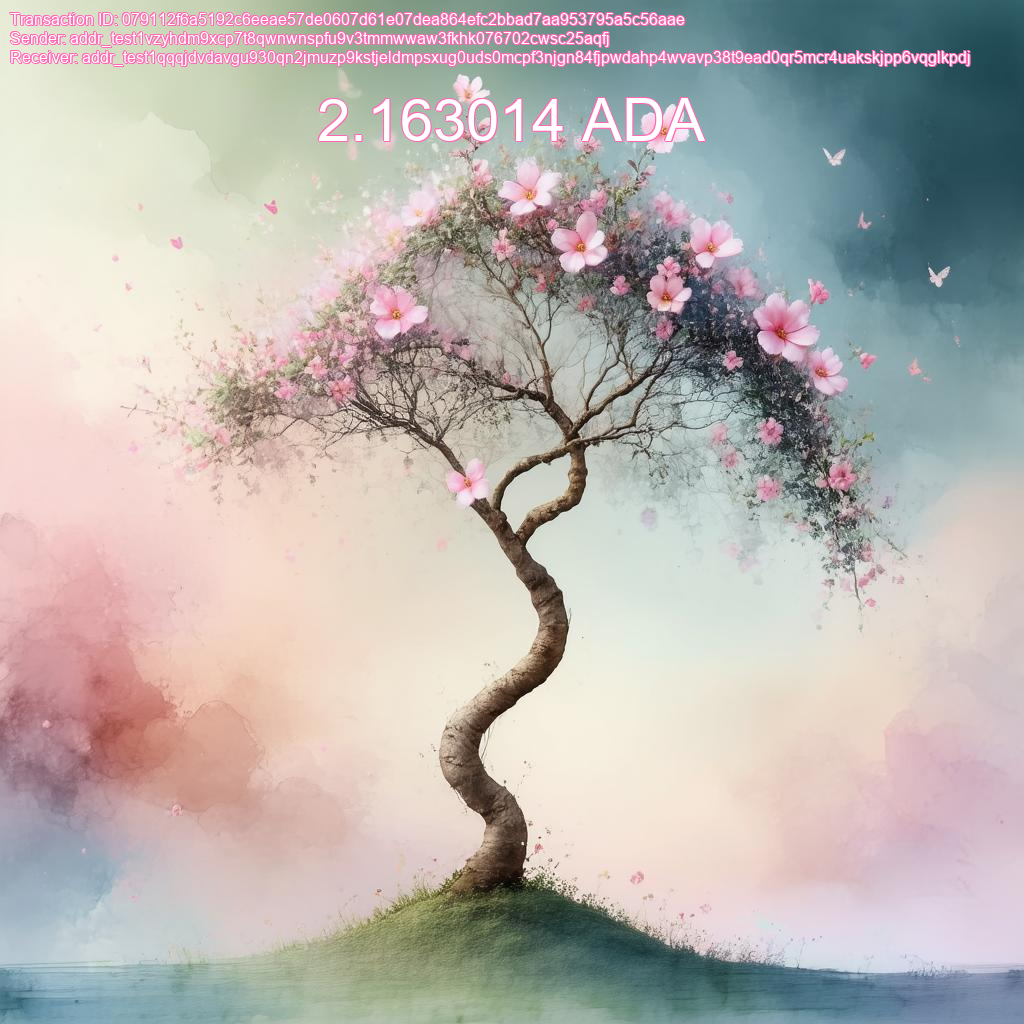

In [28]:
# Display the image
display(Img(filename))